In [1]:
import tensorflow as tf
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

## 1. Tensorflow_lite YOLO Test

In [2]:
tflite_path = "tf_lite/detect.tflite"
# out_path = "./model/quantize_frozen_graph.tflite"


# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
print(str(input_details))
output_details = interpreter.get_output_details()
print(str(output_details))


[{'name': 'normalized_input_image_tensor', 'index': 175, 'shape': array([  1, 300, 300,   3]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0078125, 128)}]
[{'name': 'TFLite_Detection_PostProcess', 'index': 167, 'shape': array([ 1, 10,  4]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'TFLite_Detection_PostProcess:1', 'index': 168, 'shape': array([ 1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'TFLite_Detection_PostProcess:2', 'index': 169, 'shape': array([ 1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'TFLite_Detection_PostProcess:3', 'index': 170, 'shape': array([1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


In [3]:
image = cv2.imread("opencv_method/dataset/real_hand/3_rgb.jpg")
#res_img = cv2.resize(image,(300,300,3),interpolation=cv2.INTER_CUBIC) 
resized = cv2.resize(image, (300,300), interpolation = cv2.INTER_AREA)

image_np_expanded = np.expand_dims(resized, axis=0)
#image_np_expanded = image_np_expanded.astype('float32')

model_interpreter_start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], image_np_expanded)
  
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
output_classes = interpreter.get_tensor(output_details[1]['index'])
output_scores = interpreter.get_tensor(output_details[2]['index'])

result = np.squeeze(output_data)
scores = np.squeeze(output_scores)
classes = np.squeeze(output_classes)
print('time took : ', time.time() - model_interpreter_start_time)
print('result:{}'.format(result))

time took :  0.3610351085662842
result:[[0.25408745 0.28433296 0.91919386 0.9928466 ]
 [0.2591154  0.55529875 0.75038725 0.9882187 ]
 [0.23998396 0.56770784 0.5671004  0.9569406 ]
 [0.54007596 0.24150959 0.7090015  0.56371486]
 [0.37660286 0.30682772 0.5565531  0.6555293 ]
 [0.34498715 0.26617473 0.79181087 0.8507344 ]
 [0.40050727 0.23843545 0.8764923  0.67825234]
 [0.37969905 0.26922008 0.7173212  0.6176853 ]
 [0.3358349  0.30645484 0.6141031  0.75129765]
 [0.2771287  0.40673587 0.6030451  0.93605006]]


In [4]:
def draw_yolo(image):
    draw_image = image.copy()
    input_size = 300
    rects = []
    for i in range(10):
        if(scores[i] > 0.5):
            left = int(result[i][1] * 640)
            top  = int(result[i][0] * 480)
            right = int(result[i][3] * 640)
            bottom = int(result[i][2] * 480)
            #rect = [left, top, right, bottom]
            #rects.append(rect)
            cv2.rectangle(draw_image, (left, top), (right, bottom), (255,0,0), 2)
            cv2.putText(draw_image, str(scores[i]), (left, top), cv2.FONT_HERSHEY_SIMPLEX,1.0, (255, 255, 255), 2)
    return draw_image

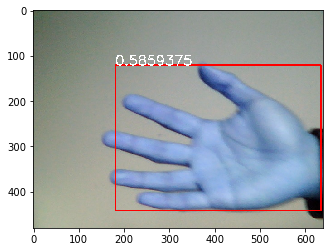

In [5]:
draw_image = draw_yolo(image)
plt.imshow(draw_image)

# 2.  Exploration TF Lite

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.contrib import quantize as contrib_quantize

### work flow

#### pipeline of tf lite
<img src=images/tflite_flow.PNG width="60%">

#### converter

(from offical document)
* TFLiteConverter.from_saved_model()：used to transform SavedModel models.
* TFLiteConverter.from_keras_model()：used to transform tf.keras models.
* TFLiteConverter.from_concrete_functions()：used to transform concrete functions.

but here I only find:
* 'from_frozen_graph',
* 'from_keras_model_file',
* 'from_saved_model',
* 'from_session',


In [19]:
tf.__version__

'1.15.0'

In [16]:
import tensorflow as tf

# 建立一个简单的模型。
root = tf.train.Checkpoint()
root.v1 = tf.Variable(3.)
root.v2 = tf.Variable(2.)
root.f = tf.function(lambda x: root.v1 * root.v2 * x)

# 保存模型。
export_dir = "/tf_lite/test_saved_model"
input_data = tf.constant(1., shape=[1, 1])
to_save = root.f.get_concrete_function(input_data)
tf.saved_model.save(root, export_dir, to_save)

# 转换模型。
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

ValueError: Attempted to save a function b'__inference_<lambda>_998' which references a symbolic Tensor Tensor("Variable_2/read:0", shape=(), dtype=float32) that is not a simple constant. This is not supported.

In [21]:
x = [-1, 0, 1, 2, 3, 4]
y = [-3, -1, 1, 3, 5, 7]

model = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(x, y, epochs=50)
 
print(model.predict([10.0]))
 
keras_file = "tf_lite/linear.hdf5"
tf.keras.models.save_model(model, keras_file)

Train on 6 samples
Epoch 1/50
6/6 [==============================] - 0s 6ms/sample - loss: 41.0174
Epoch 2/50
6/6 [==============================] - 0s 166us/sample - loss: 32.6295
Epoch 3/50
6/6 [==============================] - 0s 161us/sample - loss: 26.0229
Epoch 4/50
6/6 [==============================] - 0s 338us/sample - loss: 20.8180
Epoch 5/50
6/6 [==============================] - 0s 161us/sample - loss: 16.7160
Epoch 6/50
6/6 [==============================] - 0s 166us/sample - loss: 13.4817
Epoch 7/50
6/6 [==============================] - 0s 169us/sample - loss: 10.9304
Epoch 8/50
6/6 [==============================] - 0s 330us/sample - loss: 8.9165
Epoch 9/50
6/6 [==============================] - 0s 166us/sample - loss: 7.3255
Epoch 10/50
6/6 [==============================] - 0s 162us/sample - loss: 6.0675
Epoch 11/50
6/6 [==============================] - 0s 162us/sample - loss: 5.0714
Epoch 12/50
6/6 [==============================] - 0s 160us/sample - loss: 4.2817
E

In [22]:
#converter = lite.TocoConverter.from_keras_model_file(keras_file)
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()
open("linear.tflite", "wb").write(tflite_model)

INFO:tensorflow:Froze 2 variables.
INFO:tensorflow:Converted 2 variables to const ops.


ConverterError: See console for info.
b"'toco_from_protos' \xb2\xbb\xca\xc7\xc4\xda\xb2\xbf\xbb\xf2\xcd\xe2\xb2\xbf\xc3\xfc\xc1\xee\xa3\xac\xd2\xb2\xb2\xbb\xca\xc7\xbf\xc9\xd4\xcb\xd0\xd0\xb5\xc4\xb3\xcc\xd0\xf2\r\n\xbb\xf2\xc5\xfa\xb4\xa6\xc0\xed\xce\xc4\xbc\xfe\xa1\xa3\r\n"



In [14]:
dir(tf.lite.TFLiteConverter)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_any_optimization_enabled',
 '_calibrate_quantize_model',
 '_get_base_converter_args',
 '_grappler_config',
 '_has_valid_tensors',
 '_is_calibration_quantize',
 '_is_float16_quantize',
 '_is_int8_target_required',
 '_is_int8_weight_only_quantize',
 '_is_post_training_optimize',
 '_set_batch_size',
 '_smallest_supported_type',
 '_tf_api_names',
 '_tf_api_names_v1',
 '_validate_quantization',
 '_validate_representative_dataset',
 'convert',
 'from_frozen_graph',
 'from_keras_model_file',
 'from_saved_model',
 'from_session',
 'get_input_arrays']